In [55]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from numpy import genfromtxt
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import torch

In [56]:
import numpy as np
import copy
import scipy
from sklearn.metrics.pairwise import euclidean_distances
from scipy.optimize import minimize
import GPy
import matplotlib.pyplot as plt
from scipy import special
import math
from scipy.stats import norm
from botorch.utils.transforms import unnormalize,normalize
import torch

In [101]:
def cov_RBF(x1, x2, parameters):  
    
    lengthscale_square =   parameters[:,0]  # lengthscale^2
    variance = parameters[:,1] # sigma^2


    if x1.shape[1]!=x2.shape[1]:
        x1=np.reshape(x1,(-1,x2.shape[1]))

    Euc_dist=euclidean_distances(x1,x2)

    return variance*np.exp(-0.5*np.square(Euc_dist)/lengthscale_square)




def log_llk(X,y,parameters):

    noise_delta = 10**(-6)
    
    parameters = parameters.reshape(-1,2)

    KK_x_x=cov_RBF(X,X,parameters)+np.eye(len(X))*noise_delta     
    if np.isnan(KK_x_x).any(): #NaN
        print("nan in KK_x_x !")   

    try:
        L=scipy.linalg.cholesky(KK_x_x,lower=True)
        alpha=np.linalg.solve(KK_x_x,y)

    except: # singular
        return -np.inf
    
    try:
        first_term = -0.5*np.log(np.linalg.det(KK_x_x))
        
        KK_inv = np.linalg.inv(KK_x_x)
        second_term = -0.5* np.dot(np.dot(y.T,KK_inv),y)
            

    except: # singular
        return -np.inf

    logmarginal = first_term+second_term -0.5*len(y)*np.log(2*3.1415926)
    
    return logmarginal.item()


def optimise(X, y):

    opts ={'maxiter':1000,'maxfun':200,'disp': False}

    bounds = np.array([[0.015**2,0.6**2],[0.01,10]])
    hyper_num = 2
    restart_num = 3**hyper_num
    
    value_holder = []
    candidate_holder = []
    
    for _ in range(restart_num):
      init_hyper = np.random.uniform(bounds[:, 0], bounds[:, 1],size=(50, hyper_num))
      logllk_holder = [0]*init_hyper.shape[0]
      for ii,val in enumerate(init_hyper):           
          logllk_holder[ii] = log_llk(X,y,val) 
          
      x0=init_hyper[np.argmax(logllk_holder)] # we pick one best value from 50 random one as our initial value of the optimization

      # Then we minimze negative likelihood
      res = minimize(lambda x: -log_llk(X,y,parameters=x),x0,
                                  bounds=bounds,method="L-BFGS-B",options=opts) 

      candidate_holder.append(res.x)
      value_holder.append(log_llk(X,y,res.x))


    best_parameter = candidate_holder[np.argmax(value_holder)]
  
        
    return best_parameter




def EI(X,dim,f_best,model): # X is a 2-dimensional array because we will use it in scipy.minimize

  X = X.reshape(-1,dim)

  mean,var = model.predict(X,include_likelihood=False)
  
  var[var<10**(-12)]=10**(-12)

  z = (f_best - mean)/np.sqrt(var)        
  out=(f_best - mean) * norm.cdf(z) + np.sqrt(var) * norm.pdf(z)

  return out.ravel()  #make the shape to be 1 dimensional



def EI_acquisition_opt(model,bounds,f_best): #bound should an array of size dim*2
  dim = bounds.shape[0]
  opts ={'maxiter':50*dim,'maxfun':50*dim,'disp': False}

  restart_num = 3*dim
  X_candidate = []
  AF_candidate = []

  for i in range(restart_num):
    init_X = np.random.uniform(bounds[:, 0], bounds[:, 1],size=(30*dim, dim))
    value_holder = EI(init_X,dim,f_best,model)
      
    x0=init_X[np.argmax(value_holder)]

    res = minimize(lambda x: -EI(X=x,dim=dim,f_best=f_best,model=model),x0,
                                  bounds=bounds,method="L-BFGS-B",options=opts) #L-BFGS-B  nelder-mead(better for rough function) Powell

    X_temp =  res.x  
    AF_temp = EI(X=np.array(X_temp).reshape(-1,1),dim=dim,f_best=f_best,model=model)
    
    X_candidate.append(X_temp)
    AF_candidate.append(AF_temp)

  X_next = X_candidate[np.argmax(AF_candidate)]

  return X_next


def log_llk_warp(X,y,parameters):

    noise_delta = 10**(-6)
    
    parameters = parameters.reshape(-1,3)
    kernel_parameters = parameters[:,:2]
    c = parameters[:,-1]
    
    y_temp = np.log(y+c)
    y_temp_mean = np.mean(y_temp)
    y_warp = y_temp-y_temp_mean
    
    
    KK_x_x=cov_RBF(X,X,kernel_parameters)+np.eye(len(X))*noise_delta     
    if np.isnan(KK_x_x).any(): #NaN
        print("nan in KK_x_x !")   

    try:
        L=scipy.linalg.cholesky(KK_x_x,lower=True)
        alpha=np.linalg.solve(KK_x_x,y_warp)

    except: # singular
        return -np.inf
    
    try:
        first_term = -0.5*np.log(np.linalg.det(KK_x_x))
        
        KK_inv = np.linalg.inv(KK_x_x)
        second_term = -0.5* np.dot(np.dot(y_warp.T,KK_inv),y_warp)
            

    except: # singular
        return -np.inf
    
    
    third_term = (len(X)-1)/len(X) * np.sum( np.log(1/(y+c)) ) 

    logmarginal = first_term+second_term - 0.5*len(y)*np.log(2*3.1415926)  +third_term
    
    return logmarginal.item()


def optimise_warp(X, y):

    opts ={'maxiter':1000,'maxfun':200,'disp': False}
    
    bounds = np.array([[0.015**2,0.6**2],[0.01,10.],[10**(-5),0.3]])  
    hyper_num = 3
    restart_num = 3**hyper_num
    
    value_holder = []
    candidate_holder = []
    
    for _ in range(restart_num):
      init_hyper = np.random.uniform(bounds[:, 0], bounds[:, 1],size=(35*hyper_num, hyper_num))
      logllk_holder = [0]*init_hyper.shape[0]
      for ii,val in enumerate(init_hyper):           
          logllk_holder[ii] = log_llk_warp(X,y,val) 
          
      x0=init_hyper[np.argmax(logllk_holder)] # we pick one best value from 50 random one as our initial value of the optimization

      # Then we minimze negative likelihood
      res = minimize(lambda x: -log_llk_warp(X,y,parameters=x),x0,
                                  bounds=bounds,method="L-BFGS-B",options=opts) 

      candidate_holder.append(res.x)
      value_holder.append(log_llk_warp(X,y,res.x))


    best_parameter = candidate_holder[np.argmax(value_holder)]
  
        
    return best_parameter



def Warped_EI(X,dim,f_best,c,f_mean,model): # X is a 2-dimensional array because we will use it in scipy.minimize


  X = X.reshape(-1,dim)

  mean,var = model.predict(X,include_likelihood=False)  
  var[var<10**(-12)]=10**(-12)
  sigma = np.sqrt(var)
  mu = mean+f_mean

  C = c+f_best
  
  out = C*norm.cdf((np.log(C)-mu)/sigma)-np.exp(mu+sigma**2/2)*norm.cdf((np.log(C)-mu-sigma**2)/sigma)

  return out.ravel()  #make the shape to be 1 dimensional



def Warped_EI_acquisition_opt(model,bounds,f_best,c,f_mean): #bound should an array of size dim*2
  dim = bounds.shape[0]
  opts ={'maxiter':50*dim,'maxfun':50*dim,'disp': False}

  restart_num = 3*dim
  X_candidate = []
  AF_candidate = []

  for i in range(restart_num):
    init_X = np.random.uniform(bounds[:, 0], bounds[:, 1],size=(30*dim, dim))
    value_holder =  Warped_EI(init_X,dim,f_best,c,f_mean,model)
      
    x0=init_X[np.argmax(value_holder)]

    res = minimize(lambda x: -Warped_EI(X=x,dim=dim,f_best=f_best,c=c,f_mean=f_mean,model=model),x0,
                                  bounds=bounds,method="L-BFGS-B",options=opts) #L-BFGS-B  nelder-mead(better for rough function) Powell

    X_temp =   res.x  
    AF_temp = Warped_EI(X=np.array(X_temp).reshape(-1,1),dim=dim,f_best=f_best,c=c,f_mean=f_mean,model=model)
    
    X_candidate.append(X_temp)
    AF_candidate.append(AF_temp)

  X_next = X_candidate[np.argmax(AF_candidate)]

  return X_next



def MES(X,dim,fstar,model): 
  
  X = X.reshape(-1,dim)
  mean,var = model.predict(X,include_likelihood=False)

  var[var<10**(-12)]=10**(-12)
  gamma = -(fstar-mean)/np.sqrt(var)  

  cdf_part = norm.cdf(gamma)
  out = (gamma*norm.pdf(gamma))/(2*cdf_part)-np.log(cdf_part)

  return out.ravel() 



def MES_acquisition_opt(model,bounds,fstar): #bound should an array of size dim*2

  dim = bounds.shape[0]
  opts ={'maxiter':50*dim,'maxfun':50*dim,'disp': False}

  restart_num = 3*dim
  X_candidate = []
  AF_candidate = []

  for i in range(restart_num):
    init_X = np.random.uniform(bounds[:, 0], bounds[:, 1],size=(30*dim, dim))
    value_holder = MES(init_X,dim,fstar,model)
        
    x0=init_X[np.argmax(value_holder)]


    res = minimize(lambda x: -MES(X=x,dim=dim,fstar=fstar,model=model),x0,
                                  bounds=bounds,method="L-BFGS-B",options=opts) 

    X_temp =  res.x
    AF_temp = MES(X=np.array(X_temp).reshape(-1,1),dim=dim,fstar=fstar,model=model)
    X_candidate.append(X_temp)
    AF_candidate.append(AF_temp)

  X_next = X_candidate[np.argmax(AF_candidate)]


  return X_next

In [102]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double


from botorch.utils.sampling import draw_sobol_samples

def get_initial_points(bounds,num,device,dtype,seed=0):
    
        train_x = draw_sobol_samples(
        bounds=bounds, n=num, q=1,seed=seed).reshape(num,-1).to(device, dtype=dtype)
        
        return train_x

In [103]:
class XGBoost:
    def __init__(self,seed=1):
        # define the search range for each variable
        self.bounds = torch.tensor(np.asarray([
                                [0.,10.],  # alpha
                                  [0.,10.],# gamma 
                                  [5.,15.], #max_depth
                                  [1.,20.],  #min_child_weight
                                  [0.5,1.],  #subsample
                                  [0.1,1] #colsample
                                 ]).T)
            
        self.dim = 6
        self.fstar = 100

        self.seed= seed
        self.data = np.genfromtxt('Skin_NonSkin.txt', dtype=np.int32)
        
    def __call__(self, X): # this is actually a Branin function

        
        alpha,gamma,max_depth,min_child_weight,subsample,colsample=X[0],X[1],X[2],X[3],X[4],X[5]
        
        #data = np.genfromtxt('Skin_NonSkin.txt', dtype=np.int32)

        outputs = self.data[:,3]
        inputs = self.data[:,0:3]
        X_train1, X_test1, y_train1, y_test1 = train_test_split(inputs, outputs, test_size=0.85, random_state=self.seed)
        y_train1 = y_train1-1
        
        reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, 
                       min_child_weight=min_child_weight,colsample_bytree=colsample, n_estimators = 2, random_state=self.seed, objective = 'binary:logistic', booster='gbtree',eval_metric='logloss',silent=None)
        score = np.array(cross_val_score(reg, X=X_train1, y=y_train1).mean())
      
        return score*100
    

In [60]:
myfunction=XGBoost(999)
myfunction(np.array([ 1.36257 , 0.98294,  6.13885, 8.26313,  0.72965,  0.6373] ) )

88.54944231936643

In [51]:
myfunction(np.array([ 2.36257 , 2.98294,  9.13885, 10.26313,  0.72965,  0.72373] ) )

98.60437847648362

In [52]:
myfunction(np.array([ 7.91975295,  6.61702189, 13.38884305 , 5.54747327, 1.  ,  1.     ] ) )

99.12944416673119

In [61]:
standard_bounds=np.array([0.,1.]*6).reshape(-1,2) 
n_init = 18
iter_num = 30
N=2

In [62]:
class Trans_function:
    def __init__(self,fun,fstar):
        self.fun = fun
        self.fstar = fstar
        
    def __call__(self, X):
        y = -self.fun(X)-self.fstar
        return y

In [87]:
BO_EI = []

for exp in range(20):
    
    print(exp)

    seed = exp
    
    fun = XGBoost(seed=exp)
    dim = fun.dim
    bounds = fun.bounds
    
    fstar = -100
    fun = Trans_function(fun,fstar)
    

    X_BO = get_initial_points(bounds, n_init,device,dtype,seed=seed)
    Y_BO = torch.tensor(
        [fun(x.numpy()) for x in X_BO], dtype=dtype, device=device
    ).reshape(-1,1)

    torch.manual_seed(seed)

    best_record = [Y_BO.min().item()]

    for i in range(iter_num):
        
            train_Y = (Y_BO - Y_BO.mean()) / Y_BO.std()
            train_X = normalize(X_BO, bounds)
            
            minimal = train_Y.min().item()
            
            train_Y = train_Y.numpy()
            train_X = train_X.numpy()
            
            # train the GP
            res = optimise(train_X,train_Y)
            print('lengthscale is: ',np.sqrt(res[0])) 
            print('variance is: ',res[1])
            kernel = GPy.kern.RBF(input_dim=dim,lengthscale= np.sqrt(res[0]),variance=res[1]) 
            m = GPy.models.GPRegression(train_X, train_Y,kernel)
            m.Gaussian_noise.variance.fix(10**(-5))

            standard_next_X = EI_acquisition_opt(m,bounds=standard_bounds,f_best=minimal)
            X_next = unnormalize(torch.tensor(standard_next_X), bounds).reshape(-1,dim)            
            Y_next = torch.tensor( [fun(X_next.numpy().reshape(6,)) ]).reshape(1,1)

            # Append data
            X_BO = torch.cat((X_BO, X_next), dim=0)
            Y_BO = torch.cat((Y_BO, Y_next), dim=0)
            
            best_record.append(Y_BO.min().item())
            #print(best_record)
            
    best_record = -(np.array(best_record)+fstar)
    BO_EI.append(best_record)

0
lengthscale is:  0.3771827712793349
variance is:  0.9574568439177691
lengthscale is:  0.3584752627945785
variance is:  0.8708861433431266
lengthscale is:  0.3728749888353749
variance is:  0.8391309498449563
lengthscale is:  0.3788413619554135
variance is:  0.8063380457118258
lengthscale is:  0.38645535080967935
variance is:  0.7841914632971766
lengthscale is:  0.3908536100831841
variance is:  0.7661413056739409
lengthscale is:  0.3967818057163655
variance is:  0.7550843013722972
lengthscale is:  0.40108853178098447
variance is:  0.7451961146768862
lengthscale is:  0.4051918275737834
variance is:  0.7399494049026656
lengthscale is:  0.40660882522682285
variance is:  0.7348266570103492
lengthscale is:  0.4094808807071068
variance is:  0.7302389732753417
lengthscale is:  0.41336822037667215
variance is:  0.7315476780783995
lengthscale is:  0.41990172781092816
variance is:  0.7389651727947693
lengthscale is:  0.4219140844398057
variance is:  0.7390980636231614
lengthscale is:  0.42439250

In [109]:
BO_MES = []

for exp in range(20):
    
    print(exp)

    seed = exp
    
    fun = XGBoost(seed=exp)
    dim = fun.dim
    bounds = fun.bounds
    
    fun = Trans_function(fun,-100)

    X_BO = get_initial_points(bounds, n_init,device,dtype,seed=seed)
    Y_BO = torch.tensor(
        [fun(x.numpy())  for x in X_BO], dtype=dtype, device=device
    ).reshape(-1,1)

    torch.manual_seed(seed)
    
    fstar = 0.

    best_record = [Y_BO.min().item()]

    for i in range(iter_num):
        
            train_Y = (Y_BO - Y_BO.mean()) / Y_BO.std()
            train_X = normalize(X_BO, bounds)
            
            fstar_standard = (fstar - Y_BO.mean()) / Y_BO.std()
            fstar_standard = fstar_standard.item()
            
            train_Y = train_Y.numpy()
            train_X = train_X.numpy()
            
            # train the GP
            res = optimise(train_X,train_Y)
            print('lengthscale is: ',np.sqrt(res[0])) 
            print('variance is: ',res[1])
            kernel = GPy.kern.RBF(input_dim=dim,lengthscale= np.sqrt(res[0]),variance=res[1]) 
            m = GPy.models.GPRegression(train_X, train_Y,kernel)
            m.Gaussian_noise.variance.fix(10**(-5))

            standard_next_X = MES_acquisition_opt(m,standard_bounds,fstar_standard)
            X_next = unnormalize(torch.tensor(standard_next_X), bounds).reshape(-1,dim)            
            Y_next = torch.tensor( [fun(X_next.numpy().reshape(6,)) ]).reshape(1,1)

            # Append data
            X_BO = torch.cat((X_BO, X_next), dim=0)
            Y_BO = torch.cat((Y_BO, Y_next), dim=0)
            
            best_record.append(Y_BO.min().item())

            
    best_record = -(np.array(best_record)-100)
    BO_MES.append(best_record)

0
lengthscale is:  0.37718278335130545
variance is:  0.9574569751927808
lengthscale is:  0.3447787702864897
variance is:  0.868073209114682
lengthscale is:  0.35965142602181416
variance is:  0.8373036338331493
lengthscale is:  0.3690426148005524
variance is:  0.8103859229574925
lengthscale is:  0.37637565194167455
variance is:  0.788655415130698
lengthscale is:  0.3818775828493039
variance is:  0.7731510545624072
lengthscale is:  0.3880871882540204
variance is:  0.7634598496975837
lengthscale is:  0.39022108306021497
variance is:  0.7561754878674597
lengthscale is:  0.39435859652525507
variance is:  0.7498796463210866
lengthscale is:  0.398317649273082
variance is:  0.7472260514275999
lengthscale is:  0.4032251198895547
variance is:  0.7486952491929928
lengthscale is:  0.4083436930045751
variance is:  0.7523554207693457
lengthscale is:  0.4158074068361588
variance is:  0.7640777338278187
lengthscale is:  0.4215672592749172
variance is:  0.7728833812862501
lengthscale is:  0.42472340060

In [88]:
Warped_BO_EI = []

for exp in range(20):
    
    print(exp)

    seed = exp
    
    fun = XGBoost(seed=exp)
    dim = fun.dim
    bounds = fun.bounds
    
    fstar = -100
    fun = Trans_function(fun,fstar)
    

    X_BO = get_initial_points(bounds, n_init,device,dtype,seed=seed)
    Y_BO = torch.tensor(
        [fun(x.numpy()) for x in X_BO], dtype=dtype, device=device
    ).reshape(-1,1)

    torch.manual_seed(seed)

    best_record = [Y_BO.min().item()]

    for i in range(iter_num):
            
            print(i)
        
            train_Y = Y_BO.numpy()
            train_X = normalize(X_BO, bounds)
            train_X = train_X.numpy()
            
            # train the GP
            res = optimise_warp(train_X, train_Y)
            lengthscale = np.sqrt(res[0])
            variance = res[1]
            c = res[2]
            
            print('lengthscale is: ', lengthscale)
            print('variance is: ',variance)
            print('c is: ',c)
            
            warp_Y = np.log(train_Y+c)
            mean_warp_Y = np.mean(warp_Y) # use to predict mean
            warp_Y_standard = warp_Y-mean_warp_Y
              
            
            kernel = GPy.kern.RBF(input_dim=dim,lengthscale= lengthscale,variance=variance)  #np.sqrt(res[0])
            m = GPy.models.GPRegression(train_X, warp_Y_standard,kernel)
            m.Gaussian_noise.variance.fix(10**(-5))
            
            standard_next_X = Warped_EI_acquisition_opt(model=m,bounds=standard_bounds,f_best=best_record[-1],c=c,f_mean=mean_warp_Y)
            X_next = unnormalize(torch.tensor(standard_next_X), bounds).reshape(-1,dim)            
            Y_next = torch.tensor( [fun(X_next.numpy().reshape(6,)) ]).reshape(1,1)

            # Append data
            X_BO = torch.cat((X_BO, X_next), dim=0)
            Y_BO = torch.cat((Y_BO, Y_next), dim=0)
            
            best_record.append(Y_BO.min().item())
            print(best_record[-1])
            
    best_record = -(np.array(best_record)+fstar)        
    Warped_BO_EI.append(best_record)

0
0
lengthscale is:  0.37529790793240564
variance is:  0.7645424945336484
c is:  0.3
1.8471971050847031
1
lengthscale is:  0.34740721299768057
variance is:  0.8058664227538535
c is:  1e-05
1.7982263966218
2
lengthscale is:  0.3593611531753543
variance is:  0.7875713997069884
c is:  1e-05
1.7982263966218
3
lengthscale is:  0.3687307341963891
variance is:  0.7726878652494278
c is:  1e-05
1.7764617606599842
4
lengthscale is:  0.3778553371879921
variance is:  0.7632452919535426
c is:  1e-05
1.7764617606599842
5
lengthscale is:  0.38588431827692427
variance is:  0.7554932248711261
c is:  1e-05
1.3983322500295685
6
lengthscale is:  0.40198528820108215
variance is:  0.7845141989093819
c is:  1e-05
1.3738472658631764
7
lengthscale is:  0.4107444097275402
variance is:  0.7906504425478802
c is:  1e-05
1.3738472658631764
8
lengthscale is:  0.4162786309271873
variance is:  0.7851782988665954
c is:  1e-05
1.3738472658631764
9
lengthscale is:  0.4207096173767584
variance is:  0.781696147386983
c is:

In [92]:
np.savetxt('XGBoost6D_BO_EI', BO_EI, delimiter=',')

In [111]:
np.savetxt('XGBoost6D_BO_MES', BO_MES, delimiter=',')

In [93]:
np.savetxt('XGBoost6D_Warped_BO_EI', Warped_BO_EI, delimiter=',')

In [95]:
import os

Text(0.5, 1.0, 'XGBoost Classification 6D')

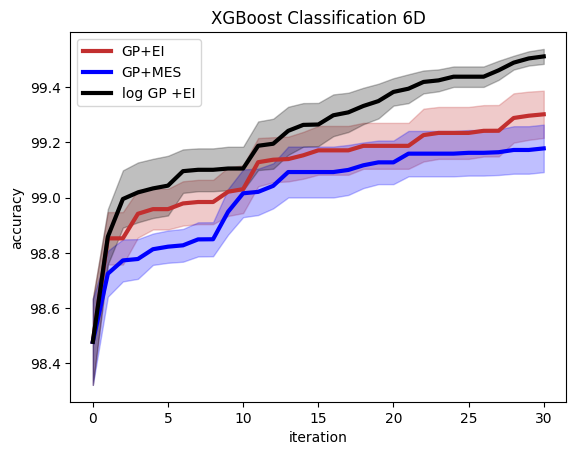

In [116]:
BO_EI = np.genfromtxt(os.path.join(os.getcwd(),'XGBoost6D_BO_EI'), delimiter=',')
BO_MES = np.genfromtxt(os.path.join(os.getcwd(),'XGBoost6D_BO_MES'), delimiter=',')
Warped_BO_EI = np.genfromtxt(os.path.join(os.getcwd(),'XGBoost6D_Warped_BO_EI'), delimiter=',')

N = 10
total_record = np.array(BO_EI)[:N,:]
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='GP+EI',color='#c22f2f')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='#c22f2f')


total_record = np.array(BO_MES)[:N,:]
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='GP+MES',color='blue')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='blue')

total_record = np.array(Warped_BO_EI)[:N,:]
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='log GP +EI',color='black')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='black')


plt.xlabel('iteration')
plt.ylabel('accuracy')

plt.legend()
plt.title('XGBoost Classification 6D')